In [118]:
import onnxruntime as ort

import matplotlib.pyplot as plt
import scipy.special
import sklearn.metrics
import seaborn as sns
sns.set()
import numpy as np
import os
import glob
from PIL import Image
import sys
sys.path.append("..")
from src.datamodule.DataLoader import PlanktonDataLoader
import hydra
from src.lib.config import Config, register_configs
from src.utils.utils import print_config
register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)
    
import pytorch_lightning as pl
from natsort import natsorted

<class 'ValueError'>


In [7]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/klas_supervised", "random_seed=7", "strategy=SingleDevice"])

Global seed set to 7


In [8]:
train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup()

111it [00:00, 5242.88it/s]                                                                                                                                                                                                                                        | 0/21 [00:00<?, ?it/s]
6480it [00:00, 8562.31it/s]
127it [00:00, 11423.23it/s]███████████████▊                                                                                                                                                                                                               | 2/21 [00:00<00:07,  2.55it/s]
143it [00:00, 12140.91it/s]
137it [00:00, 11836.60it/s]
412it [00:00, 13274.85it/s]
18it [00:00, 6127.05it/s]
226it [00:00, 11500.31it/s]
0it [00:00, ?it/s]
85it [00:00, 9530.22it/s]
1736it [00:00, 18833.69it/s]█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               

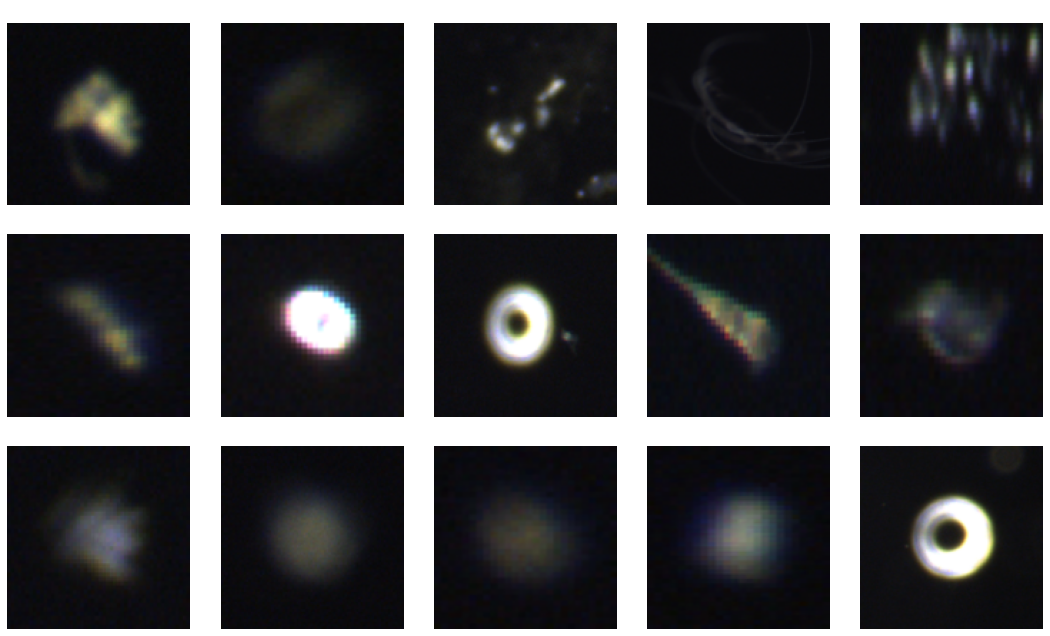

In [10]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(15,9))
dataloader = datamodule.test_dataloader()

for i, batch in enumerate(dataloader):
    ax = axes.flatten()[i]
    example_input, label = batch
    example_input = example_input.cpu().numpy()
    ax.imshow(np.moveaxis(example_input[0], 0, -1))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(label[-1][0], color="white")
    if i >=14:
        break

plt.tight_layout()
plt.savefig("example_images_raw.png", dpi=600, transparent=True)

In [121]:
onnx_files = []
with open("result_paths.txt", "r") as f:
    for line in f:
        file_path = os.path.join(line.strip(), "logs/checkpoints/model_*.onnx")
        all_onnx_files = glob.glob(file_path)
        if len(all_onnx_files) >= 1:
            onnx_file = natsorted(all_onnx_files)[-1]
            onnx_files.append(onnx_file)
            print(onnx_file)
onnx_files = natsorted(onnx_files)

/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/0/logs/checkpoints/model_99.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/0/logs/checkpoints/model_99.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/1/logs/checkpoints/model_199.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/1/logs/checkpoints/model_199.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/2/logs/checkpoints/model_299.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/2/logs/checkpoints/model_299.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/3/logs/checkpoints/model_599.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/3/logs/checkpoints/model_599.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/4/logs/checkpoints/model_1199.onnx
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/4/log

['/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/0/logs/checkpoints/model_99.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/0/logs/checkpoints/model_99.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/1/logs/checkpoints/model_199.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/1/logs/checkpoints/model_199.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/2/logs/checkpoints/model_299.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/2/logs/checkpoints/model_299.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/3/logs/checkpoints/model_599.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-36-23/3/logs/checkpoints/model_599.onnx',
 '/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/4/logs/checkpoints/model_1199.onnx',
 '/gpfs/work/machnitz/plankton_logs/ju

In [131]:
ort.get_device()

'GPU'

In [132]:
# init onnx:
for ONNX_FILE in onnx_files:
    options = ort.SessionOptions()
    options.inter_op_num_threads = 1
    options.intra_op_num_threads = 1

    ort_sess = ort.InferenceSession(ONNX_FILE, sess_options=options, providers=["CUDAExecutionProvider"])
    ort_sess.get_inputs()[0].name

    # make some prediction from the loaded onnx model:

    input_name = ort_sess.get_inputs()[0].name
    output_name = ort_sess.get_outputs()[0].name

    predicted_probabilities = np.empty(shape=(len(dataloader.dataset), ort_sess.get_outputs()[0].shape[1]))
    targets = np.empty(shape=(len(dataloader.dataset), 1))
    predicted_labels = np.empty_like(targets)
    counter = 0
    for batch in dataloader:
        x, y = batch
        predicted_probabilities[counter : counter + x.shape[0]] = ort_sess.run([output_name], {input_name: x.cpu().numpy()})[0]
        predicted_labels = scipy.special.softmax(predicted_probabilities, axis=1).argmax(axis=1)
        targets[counter : counter + x.shape[0]] = y[0]
        counter += x.shape[0]
    print(sklearn.metrics.accuracy_score(y_true=targets, y_pred=predicted_labels))

0.4529198100027941
0.00866163732886281
0.5440067057837384
0.07935177423861414
0.6552109527801062
0.06370494551550712
0.6996367700474994
0.16568873987147248
0.7342833193629505
0.10282201732327466
0.761385861972618
0.06314613020396759
0.7655769768091646
0.21067337245040513
0.7731209835149483
0.2548197820620285
0.7845766974015088
0.2673931265716681
0.7985470801899972
0.4098910310142498
0.8214585079631181
0.6708577815032132
0.8415758591785415
0.7876501816149762
0.8429728974573903
0.8080469404861693
0.8466051969823973
0.8468846046381671


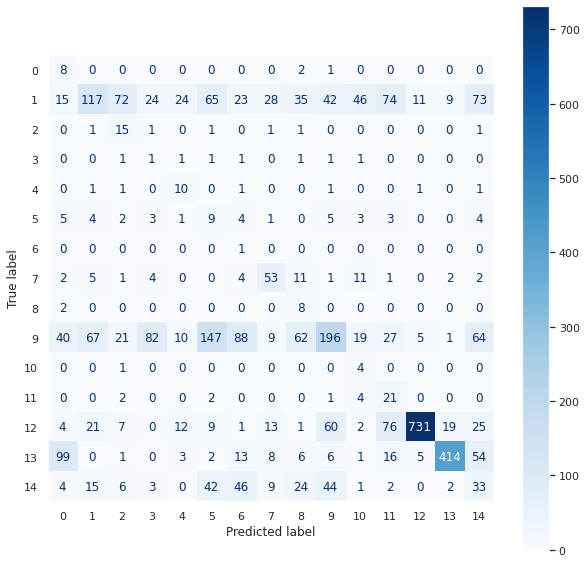

In [128]:
cm = sklearn.metrics.confusion_matrix(y_true=targets, y_pred=predicted_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues")
ax.grid(False)

In [91]:
targets

array([[ 9.],
       [ 9.],
       [13.],
       ...,
       [13.],
       [ 9.],
       [12.]])

25.0